In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path="/Users/daniel.bustillo/Documents/thesis"

os.chdir(path)

In [3]:
home_a = pd.read_csv("Dataset/home_a.csv",infer_datetime_format=True, parse_dates=True, index_col=0)
home_b = pd.read_csv("Dataset/home_b.csv",infer_datetime_format=True, parse_dates=True, index_col=0)
home_c = pd.read_csv("Dataset/home_c.csv",infer_datetime_format=True, parse_dates=True, index_col=0)
home_d = pd.read_csv("Dataset/home_d.csv",infer_datetime_format=True, parse_dates=True, index_col=0)
home_f = pd.read_csv("Dataset/home_f.csv",infer_datetime_format=True, parse_dates=True, index_col=0)
home_g = pd.read_csv("Dataset/home_g.csv",infer_datetime_format=True, parse_dates=True, index_col=0)
home_h = pd.read_csv("Dataset/home_h.csv",infer_datetime_format=True, parse_dates=True, index_col=0)

In [4]:
homes= [home_a, home_b, home_c, home_d, home_f, home_g, home_h]

In [5]:


homes =[home.loc[:,["total"]] for home in homes]

In [6]:
homes1= homes[0].join(homes[1], how='outer',lsuffix="_a" , rsuffix="_b")
homes2= homes1.join(homes[2], how='outer', rsuffix="_c")
homes3 = homes2.join(homes[3], how='outer', lsuffix="_c", rsuffix="_d")
homes4 = homes3.join(homes[4], how='outer', rsuffix="_f")
homes5 = homes4.join(homes[5], how='outer', lsuffix="_f", rsuffix="_g")
homes= homes5.join(homes[6], how='outer', lsuffix="_g", rsuffix="_h")


In [7]:
homes=homes.rename({"total":"total_h"},axis=1)

In [8]:
homes.to_csv("homes.csv")

<AxesSubplot:xlabel='Date & Time'>

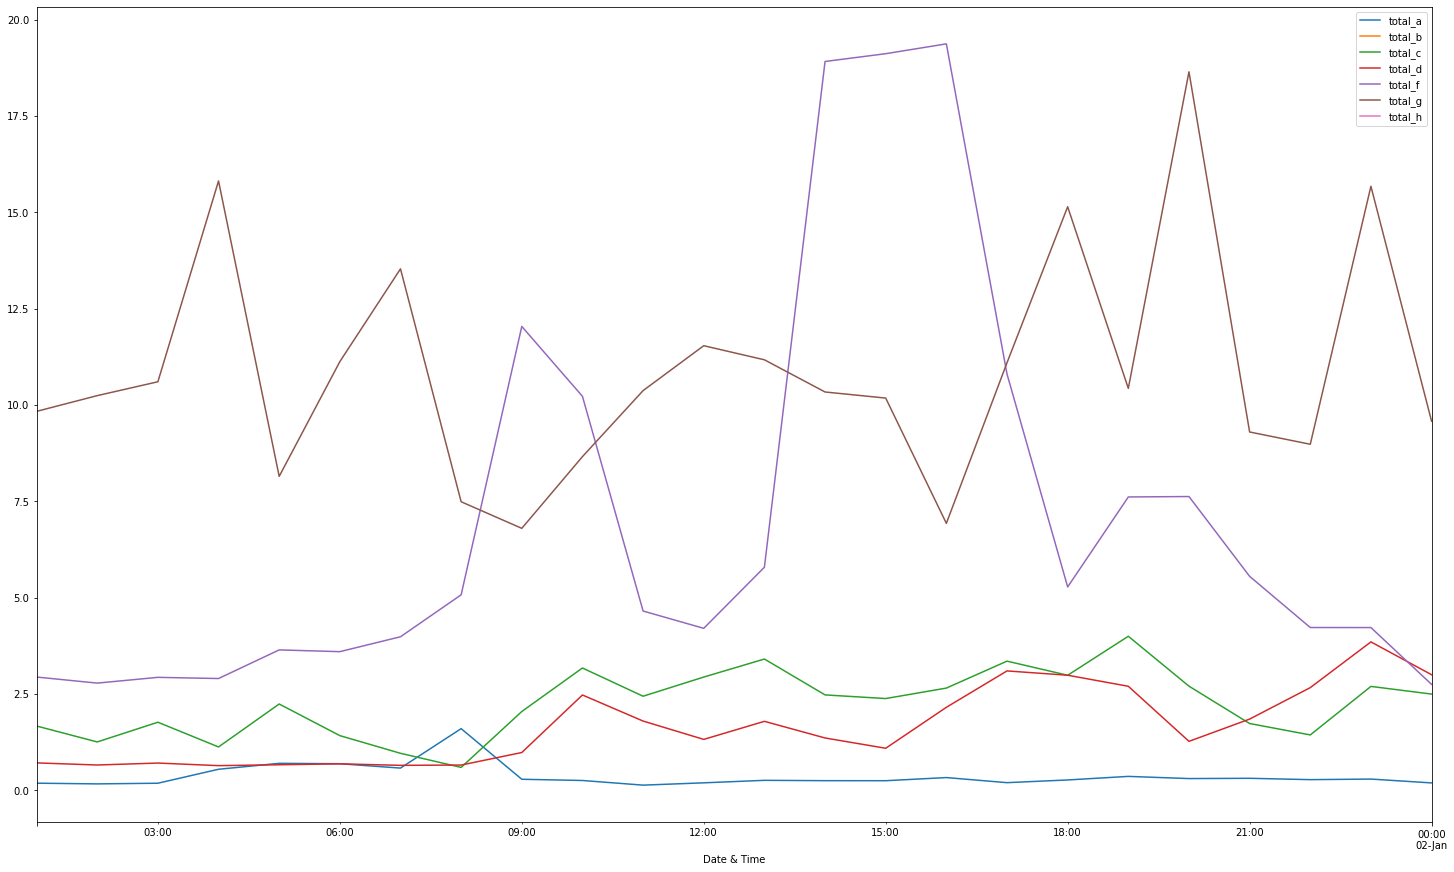

In [9]:
homes.loc[(homes.index>"2016-01-01")&(homes.index<="2016-01-02")].plot(figsize=(25,15))

## Using XGBoost for Time Series forecasting

In [10]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error
import os
import re
from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
from matplotlib.patches import Patch

plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
import warnings
warnings.filterwarnings('ignore')

In [195]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(np.asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions
 


>expected=42.0, predicted=44.5
>expected=53.0, predicted=42.5
>expected=39.0, predicted=40.3
>expected=40.0, predicted=32.5
>expected=38.0, predicted=41.1
>expected=44.0, predicted=45.3
>expected=34.0, predicted=40.2
>expected=37.0, predicted=35.0
>expected=52.0, predicted=32.5
>expected=48.0, predicted=41.4
>expected=55.0, predicted=46.6
>expected=50.0, predicted=47.2
MAE: 5.957


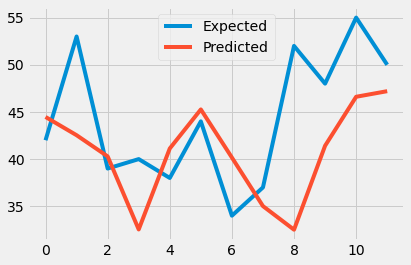

In [196]:
# load the dataset
series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [203]:
values1= homes['total_a'].dropna().values

17614

In [204]:
data = series_to_supervised(values1, n_in=6)

IndexError: tuple index out of range

In [201]:
data

array([[35., 32., 30., ..., 44., 29., 45.],
       [32., 30., 31., ..., 29., 45., 43.],
       [30., 31., 44., ..., 45., 43., 38.],
       ...,
       [40., 38., 44., ..., 37., 52., 48.],
       [38., 44., 34., ..., 52., 48., 55.],
       [44., 34., 37., ..., 48., 55., 50.]])

In [224]:
# Normal way
homes

,total_a,total_b,total_c,total_d,total_f,total_g,total_h,date
Date & Time,,,,,,,,
2014-01-01 00:00:00,NaN,1.676843,2.689820,NaN,2.060571,NaN,NaN,2014-01-01 00:00:00
2014-01-01 01:00:00,NaN,2.167156,1.518391,NaN,1.212912,NaN,NaN,2014-01-01 01:00:00
2014-01-01 02:00:00,NaN,1.102414,1.963862,NaN,1.342836,NaN,NaN,2014-01-01 02:00:00
2014-01-01 03:00:00,NaN,1.910317,2.223021,NaN,1.549448,NaN,NaN,2014-01-01 03:00:00
2014-01-01 04:00:00,NaN,1.479763,1.855156,NaN,2.604672,NaN,NaN,2014-01-01 04:00:00
...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,0.177386,NaN,NaN,8.789098,1.479447,0.669979,NaN,2016-12-31 19:00:00
2016-12-31 20:00:00,0.199725,NaN,NaN,8.362464,1.439440,0.234510,NaN,2016-12-31 20:00:00
2016-12-31 21:00:00,0.222266,NaN,NaN,6.216546,1.410874,0.278918,NaN,2016-12-31 21:00:00


In [11]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    cols= df.columns
    
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['night'] = np.where((df['hour']>=18)| (df['hour']<6),1,0)
    # df['lag_hour'] = df['total'].shift(periods=1)
    # df['lag_day'] = df['total'].shift(periods=24)
    # df['lag_week'] = df['total'].shift(periods=168)
    
    # X = df[cols]
    # X= X.drop(label, axis=1)
    # if label:
    #     y = df[label]
    #     return X, y
    # return X, cols


In [12]:
homes["date"]=homes.index

In [13]:
homes['hour'] = homes['date'].dt.hour
homes['dayofweek'] = homes['date'].dt.dayofweek
homes['quarter'] = homes['date'].dt.quarter
homes['month'] = homes['date'].dt.month
homes['year'] = homes['date'].dt.year
homes['dayofyear'] = homes['date'].dt.dayofyear
homes['dayofmonth'] = homes['date'].dt.day
homes['night'] = np.where((homes['hour']>=18)| (homes['hour']<6),1,0)

<AxesSubplot:ylabel='Date & Time'>

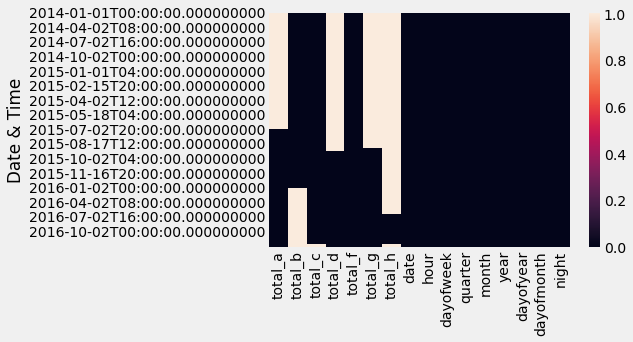

In [14]:
sns.heatmap(homes.isna())

In [41]:
# Split train-val-test
# ==============================================================================
# end_train = '2016-07-31 23:00:00'
# end_validation = '2016-10-31 23:00:00'

end_train = '2015-06-30 23:00:00'
end_validation = '2015-10-31 23:00:00'

# end_train = '2016-07-31 23:00:00'
# end_validation = '2016-10-31 23:00:00'
train = homes.loc[homes.index<end_train]
val   = homes.loc[(homes.index>=end_train)&(homes.index<end_validation)]
test  = homes.loc[homes.index>=end_validation]

print(f"Dates train      : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Dates validation : {val.index.min()} --- {val.index.max()}  (n={len(val)})")
print(f"Dates test       : {test.index.min()} --- {test.index.max()}  (n={len(test)})")


Dates train      : 2014-01-01 00:00:00 --- 2015-06-30 22:00:00  (n=17446)
Dates validation : 2015-06-30 23:00:00 --- 2015-10-31 22:00:00  (n=5904)
Dates test       : 2015-10-31 23:00:00 --- 2016-12-31 23:00:00  (n=11714)


In [16]:
train = train[train['total_a'].notna()]

In [17]:
X_train =train[['total_b', 'total_c',"total_d","total_f","total_g", "total_h","hour","dayofweek","quarter","month","year","dayofyear","dayofmonth","night"]]
y_train = train['total_a']

X_val =val[['total_b', 'total_c',"total_d","total_f","total_g", "total_h","hour","dayofweek","quarter","month","year","dayofyear","dayofmonth","night"]]
y_val = val['total_a']

X_test =test[['total_b', 'total_c',"total_d","total_f","total_g", "total_h","hour","dayofweek","quarter","month","year","dayofyear","dayofmonth","night"]]
y_test = test['total_a']

In [18]:
reg = xgb.XGBRegressor()


In [22]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

In [23]:
xgbgrid= GridSearchCV(reg, parameters, n_jobs=5, cv=2)

In [ ]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

In [25]:
xgbgrid.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:0.34758	validation_1-rmse:0.34515
[0]	validation_0-rmse:0.34752	validation_1-rmse:0.34591
[0]	validation_0-rmse:0.34746	validation_1-rmse:0.34534
[0]	validation_0-rmse:0.34720	validation_1-rmse:0.34551
[0]	validation_0-rmse:0.34734	validation_1-rmse:0.34527
[1]	validation_0-rmse:0.34538	validation_1-rmse:0.34329
[1]	validation_0-rmse:0.34687	validation_1-rmse:0.34492
[1]	validation_0-rmse:0.34634	validation_1-rmse:0.34453[1]	validation_0-rmse:0.34507	validation_1-rmse:0.34311

[2]	validation_0-rmse:0.34338	validation_1-rmse:0.34212
[1]	validation_0-rmse:0.34483	validation_1-rmse:0.34302
[2]	validation_0-rmse:0.34432	validation_1-rmse:0.34244
[2]	validation_0-rmse:0.34369	validation_1-rmse:0.34179
[2]	validation_0-rmse:0.34293	validation_1-rmse:0.34178
[3]	validation_0-rmse:0.34140	validation_1-rmse:0.34031
[3]	validation_0-rmse:0.34149	validation_1-rmse:0.33949
[2]	validation_0-rmse:0.34250	validation_1-rmse:0.34163
[4]	validation_0-rmse:0.33966	validation_1-rmse:

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1,
                                    enable_categorical=False, gamma=0,
                                    gpu_id=-1, importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=100...
                                    num_parallel_tree=1, predictor='auto',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_par

In [26]:
xgbgrid.cv_results_

{'mean_fit_time': array([5.80903316, 6.65457463, 7.65961087, 3.65604353, 4.51024628,
        5.19375944, 3.51995969, 4.39906442, 3.67345405]),
 'std_fit_time': array([1.53669786, 1.64879441, 2.17024601, 0.63763452, 0.35331559,
        0.57770443, 0.17833352, 0.24776852, 0.47986507]),
 'mean_score_time': array([0.01039183, 0.01562107, 0.01959562, 0.00955307, 0.01636767,
        0.00991845, 0.01516593, 0.00886703, 0.00758851]),
 'std_score_time': array([0.00046599, 0.00099814, 0.00566554, 0.00155103, 0.00361228,
        0.00017452, 0.00070083, 0.00111985, 0.00010931]),
 'param_colsample_bytree': masked_array(data=[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.03, 0.03, 0.03, 0.05, 0.05, 0.05, 0.07, 0.07, 0.07],
              mask=[False, False, False, False, False, False, False, False,
    

In [27]:
test['Prediction'] = xgbgrid.predict(X_test)

In [28]:
val['Prediction'] = xgbgrid.predict(X_val)

<AxesSubplot:xlabel='Date & Time'>

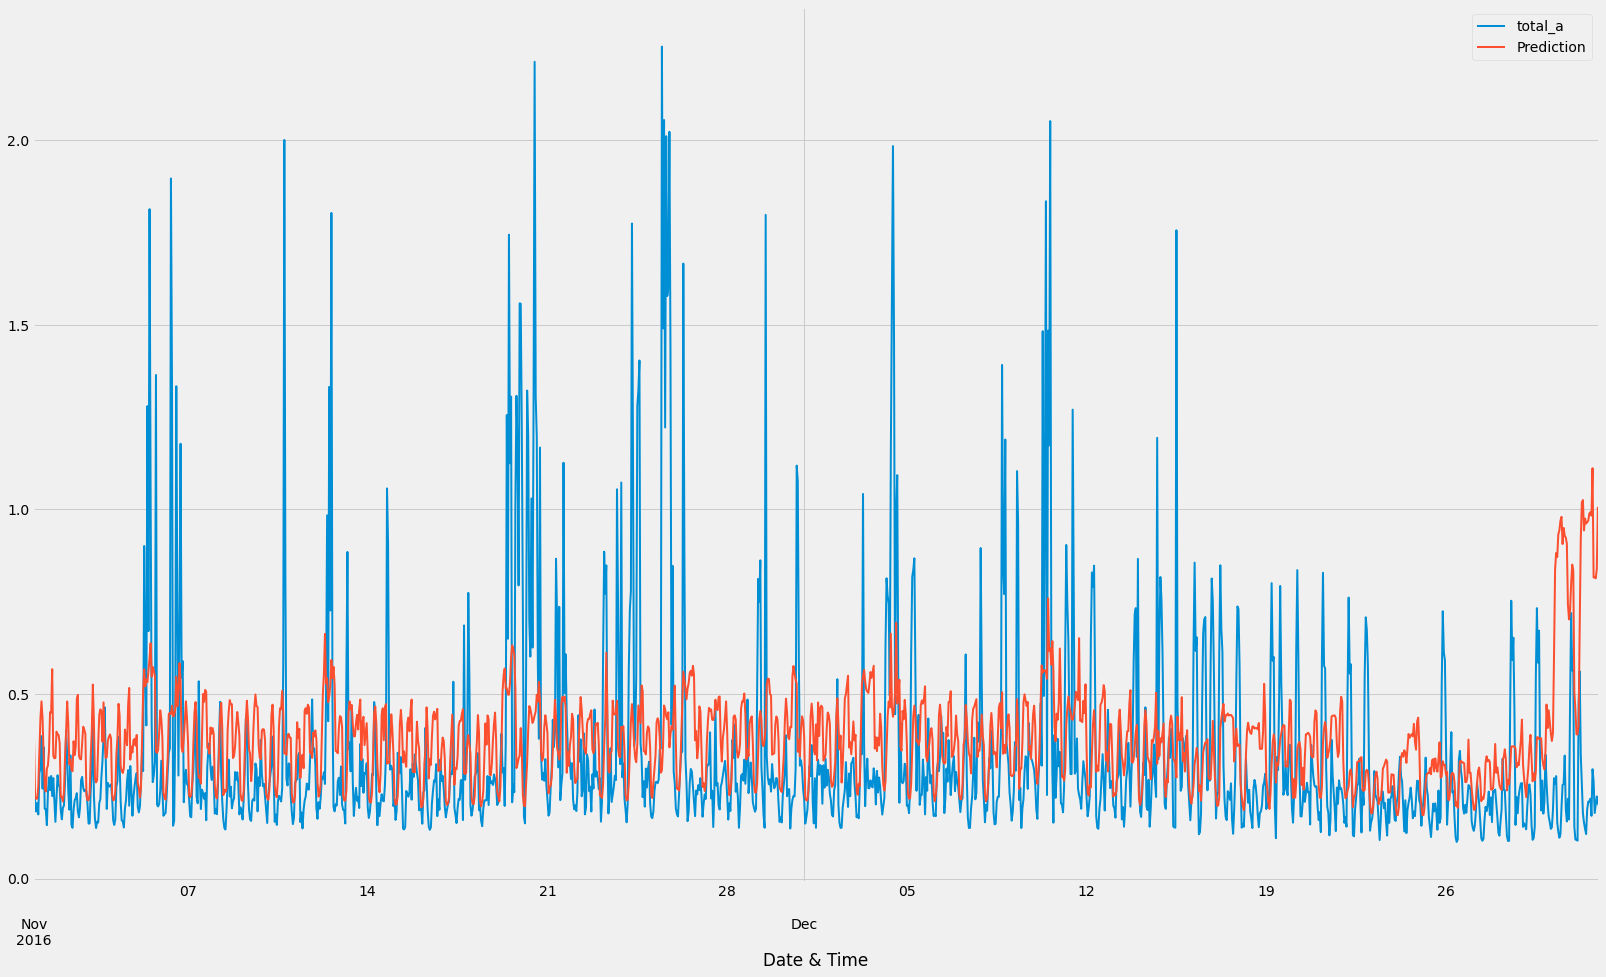

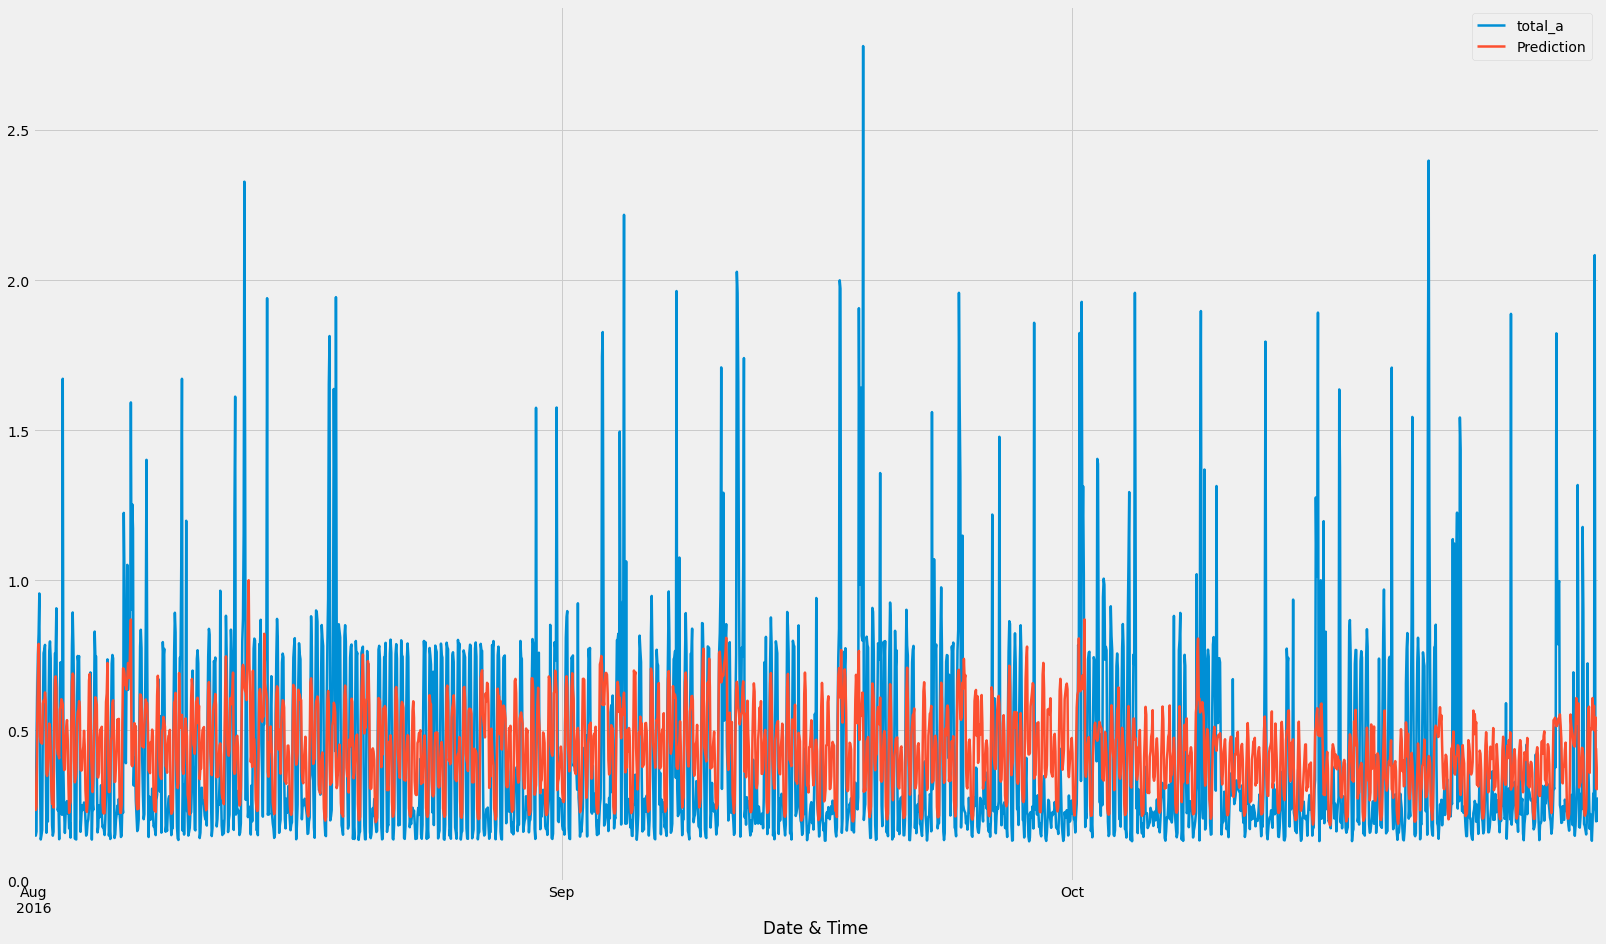

In [36]:
test[['total_a',"Prediction"]].plot(figsize=(25,15), lw=2)
val[['total_a',"Prediction"]].plot(figsize=(25,15), lw=2.5)

In [89]:
predictions = pd.DataFrame()

In [90]:
#Create a function that iterates on the home datasets and fits a model for each home

def home_fit(total, train=train, test=test, val=val, parameters= parameters, predictions= predictions):


    train = train[train[total].notna()]
    val= val[val[total].notna()]
    test = test[test[total].notna()]
    X_train = train.drop([total,'date'], axis=1)
    y_train = train[total]

    X_val = val.drop([total,"date"], axis=1)
    y_val = val[total]

    X_test = test.drop([total, 'date'], axis=1)
    y_test = test[total]

    timesplit = TimeSeriesSplit(n_splits=10)

    reg= XGBRegressor()
    xgbgrid= GridSearchCV(reg, parameters, n_jobs=5, cv=timesplit)

    xgbgrid.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train
    
    pred = xgbgrid.predict(X_test)
    predictions.append(pred)
    
    

In [91]:
predictions

""


In [92]:

home_fit("total_b")

[0]	validation_0-rmse:2.69270	validation_1-rmse:3.77922
[0]	validation_0-rmse:2.68124	validation_1-rmse:3.74734
[0]	validation_0-rmse:2.69842	validation_1-rmse:3.78796
[0]	validation_0-rmse:2.68516	validation_1-rmse:3.75614
[0]	validation_0-rmse:2.68488	validation_1-rmse:3.75310
[1]	validation_0-rmse:2.66522	validation_1-rmse:3.75186
[1]	validation_0-rmse:2.64133	validation_1-rmse:3.68939
[1]	validation_0-rmse:2.64248	validation_1-rmse:3.70010
[1]	validation_0-rmse:2.67280	validation_1-rmse:3.76362
[1]	validation_0-rmse:2.64787	validation_1-rmse:3.69872
[2]	validation_0-rmse:2.59668	validation_1-rmse:3.61873
[2]	validation_0-rmse:2.60378	validation_1-rmse:3.64721
[2]	validation_0-rmse:2.63932	validation_1-rmse:3.72564
[2]	validation_0-rmse:2.64761	validation_1-rmse:3.73797
[2]	validation_0-rmse:2.60696	validation_1-rmse:3.64315
[3]	validation_0-rmse:2.55729	validation_1-rmse:3.56143
[3]	validation_0-rmse:2.56837	validation_1-rmse:3.59499
[3]	validation_0-rmse:2.61240	validation_1-rmse:

KeyboardInterrupt: 

In [46]:
from xgboost import plot_importance, plot_tree

In [85]:
predictions

[]

In [100]:
len(X_train)/24

580.875

In [111]:
#Time series split
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV

timesplit= TimeSeriesSplit(n_splits=10)

In [112]:
X = homes.drop(['date', 'total_a'], axis=1)
y= homes['total_a']

In [113]:
for train_index, test_index in timesplit.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = homes[train_index], homes[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [   0    1    2 ... 3191 3192 3193] TEST: [3194 3195 3196 ... 6378 6379 6380]


KeyError: "None of [Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,\n            ...\n            3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193],\n           dtype='int64', length=3194)] are in the [columns]"

In [102]:
reg= XGBRegressor()

In [103]:
xgbgrid1 = GridSearchCV(reg, param_grid=parameters,cv=timesplit)

In [104]:
xgbgrid1.fit(X_train, y_train)

KeyboardInterrupt: 